If you want to see a specific genome id you can set the variable [here](#SET-GENOME)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
from collections import namedtuple
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    if type(N) is tuple:
        params.set_size_inches((plSize[0]*N[0], plSize[1]*N[1]))
    else:
        params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

In [4]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/indian_lake_bac/'
first_order = 'A'
second_order = 0
save = True
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [5]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header.csv', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck.csv', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,type,class,num_genes,new_type_group
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,8316,8345,JQGS01000146,2,JQGS01000093_1_2,81.2531,32,12729,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTCTACGGAG,3,3,2,RNA+,JQGS01000146_17,UNCLASSIFIED,0.045455,middle,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10479,10450,JQGS01000075,2,JQGS01000093_1_2,81.2531,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTCTATGGTG,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.8750,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.0000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE
100053.4,ACGCGCAGAAATATCAGGGTGCTGCCGTTCG,39170,39200,JQGS01000037,23,JQGS01000093_1_23,100.0000,31,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAGGCGT,3,2,2,RNA+,JQGS01000037_54,UNKNOWN,1.000000,tail,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE


In [6]:
df_contigs_size = pd.read_csv(data_folder + 'contig_metadata_patric_genomes.csv', sep='\t', 
                        names=['genome_id', 'contig', 'size'], 
                         dtype={'genome_id': str, 'size': int}).set_index('genome_id')
df_contigs_size.head()

,contig,size
genome_id,,
100053.4,JQGS01000001,2023
100053.4,JQGS01000002,25623
100053.4,JQGS01000003,11202
100053.4,JQGS01000004,109309
100053.4,JQGS01000005,13452


In [7]:
df_genome_info = pd.read_csv(data_folder + 'genome_info.csv', sep='\t',
                            names=['genome_id', 'name'],
                            dtype={'genome_id': str}).set_index('genome_id')
df_genome_info.head()

,name
genome_id,
100053.4,Leptospira alexanderi strain 56650
100053.5,Leptospira alexanderi strain 56643
100053.6,Leptospira alexanderi strain 56640
100053.7,Leptospira alexanderi strain 56159
100053.8,Leptospira alexanderi strain 56659


In [8]:
df_phages = pd.read_csv(data_folder + 'phages.coords.csv', sep='\t',
                       names=['genome_id', 'contig', 'phage_group', 's', 'e', 'gene_start', 'gene_end'],
                       dtype={'genome_id': str}).set_index('genome_id')
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3,2250.0,51967.0,2.0,58.0


In [9]:
df_arrays = pd.read_csv(data_folder + 'spacers.info.csv', sep='\t',
                       names=['genome_id', 'contig', 'array_id', 's', 'e', 'ori', 'size', 'type', 'conf', 'repeat'], 
                       dtype={'genome_id': str}).set_index('genome_id')
df_arrays.head()

,contig,array_id,s,e,ori,size,type,conf,repeat
genome_id,,,,,,,,,
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NaN,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NaN,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NaN,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NaN,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NaN,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


In [10]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


### Remove uninteresting duplicates

In [11]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

In [12]:
# Remove double arrays (same seq, same hit, same array location)
# df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

# SET GENOME
Here is a list of interesting genomes you can look at. 

In [13]:
genome = "907.4"  # Priming (CAS-TypeIC/F)
genome = "1049978.3"  # Phage and more (CAS-TypeIE)
genome = "1049982.3"  # Everywhere (CAS-TypeIE)
genome = "1071918.3"  # Everywhere Hotspots? (CAS-TypeIIC)
genome = "1121114.4"  # Phage (CAS-TypeIC)
genome = "1121370.3"  # All in phage (CAS-TypeIE) (The only CRISPR array that is confirmed, does not have selfhits.)
genome = "1121910.3"  # Phage and outside (CAS-TypeIF)
genome = "1121910.4"  # In phage (CAS-TypeIF)
genome = "1196095.186"  # !! Gene clustered !! (CAS-TypeIF)
genome = "1218600.3"  # Everywhere (CAS-TypeIE)
genome = "1223544.3"  # All in phage (CAS-TypeIE)
genome = "1310619.3"  # Mostly in phage (CAS-TypeIF)
genome = "1314.299"  # In phage and outside (CAS-TypeIC)
genome = "1334.46"  # In phages (CAS-TypeIC/IIA)
genome = "1341639.3"  # In phages (CAS-TypeIF)
genome = "1384589.3"  # In phages (CAS-TypeIE)
genome = "1477.15"  # In phages (CAS-TypeIC)
genome = "1496.1488"  # In phages (CAS-TypeIB)
genome = "1496.2099"  # In phages (CAS-TypeIB)
genome = "1507806.28"  # In phages (CAS-TypeIB)
genome = "1531.4"  # In phages (CAS-TypeIC)
genome = "1564506.4"  # In phages (CAS)
genome = "1581116.3"  # In phages (CAS-TypeIE)
genome = "1657.3"  # In phages (CAS-TypeIE)
genome = "1768.22"  # In phages (CAS-TypeIU)
genome = "1795832.3"  # In phages (CAS-TypeIC)
genome = "1941207.3"  # In phages and outside (NOCAS)
genome = "1965578.3"  # In a phage (CAS-TypeIC)
genome = "287.1029"  # A cluster in a region with a lot of unclassified genes (perhaps phage region missed by virsorter) (CAS-TypeIF)
genome = "294671.3"  # All phage (TypeIIIA/IB)
genome = "31973.4"  # Phage and everywhere (CAS-TypeIB)
genome = "379597.3"  # In phage (CAS-TypeIF)
genome = "386891.25"  # In phage (TypeVA, TypeIC, TypeIIIB)
genome = "39482.3"  # Interesting hotspots ??!! (TypeIC (2x), TypeIII?)
genome = "525268.3"  # All in a phage (CAS-TypeIE)
genome = "64187.137"  # In phage and a bit around (CAS-TypeIC)
genome = "64187.148"  # In phage and outside (CAS-TypeIC)
genome = "64187.210"  # In phage and outside (CAS-TypeIC)
genome = "64187.219"  # In phage and outside (CAS-TypeIC)
genome = "756272.5"  # All in phage (CAS-TypeIC)
genome = "837.101"  # Mostly in phage (CAS-TypeVIB1/CAS)
genome = "31899.10"  # DSMZ
genome = "1217647.3"  # Baumanii
genome = "1217635.3"  # Baumanii

# This genome is now used:
genome = "907.4"  # Priming (CAS-TypeIC/F)

genome = "1196095.186"  # !! Gene clustered !! (CAS-TypeIF)


lake_bacteria = ['64187.128', '64187.133', '64187.136', '64187.137', '64187.140',
       '64187.148', '64187.149', '64187.153', '64187.158', '64187.205',
       '64187.209', '64187.210', '64187.217', '64187.219', '64187.223',
       '64187.87', '64187.88', '64187.90', '64187.93', '64187.99']

plot_lake_bacteria = False  # If this is true the above list of genome id's will be plotted.


if False:
    from subprocess import run
    import time
    for genome in lake_bacteria:
        command = ('scp "alive.bio.uu.nl:/hosts/linuxhome/mgx/DB/PATRIC/patricdb-201*/%s.fna" /home/hielke/bep/genomes' 
             % genome)
        time.sleep(5)
        print(command)
        print(run(command, shell=True))

In [14]:
from collections import namedtuple
Genome = namedtuple("Genome", ['id', 'name', 'max_length', 'hits', 'contigs', 
                               'start_dict', 'len_dict', 'phages', 'arrays', 'virsorter_coords'])

def get_genome_info(genome, ident=90, verbose=True):
    """A named tuple with the information of the genome is returned."""
    dfa = df.loc[[genome]].query('hit_ident > @ident')
    dfa = dfa.assign(orientation = 0 > dfa['c_1'] - dfa['c_2'])  # True: forwards // False: backwards
    dfa_contigs_size = df_contigs_size.reset_index().query('genome_id == @genome').pipe(
        lambda d: d.assign(
            cumsum=np.concatenate((
                [0], 
                d['size'].cumsum().values[:-1]
            ))
        )
    ).set_index('contig')

    start_dict = {k.replace(".", "_"): v for k, v in dfa_contigs_size['cumsum'].to_dict().items()}
    len_dict = {k.replace(".", "_"): v for k, v in dfa_contigs_size['size'].to_dict().items()}
    
    dfa = dfa.pipe(lambda d:
         d.assign(
             start_genome = d.apply(
                 lambda x: (int(x['c_1']) + int(start_dict[x['contig_hit']])), axis=1
             )
        )
    )
    

    from operator import itemgetter
    max_contig, start_max = max(start_dict.items(), key=itemgetter(1))
    max_length = start_max + len_dict[max_contig]
    if verbose:
        print(start_max)
        print(max_length)
    
    dfa_phages = df_phages.loc[[genome]]
    
    total_len = dfa_contigs_size.iloc[-1]['size'] + dfa_contigs_size.iloc[-1]['cumsum']
    dfa_phages = dfa_phages.assign(size=dfa_phages['e'] - dfa_phages['s'])
    total_vir = dfa_phages['size'].sum()
    if verbose:
        print("%.2f %% of the genome is phage DNA" % ((total_vir / total_len) * 100))
        print("%.2f %% of the selfhits are located at phage DNA" % (sum(dfa['with_phage'] == 2) / len(dfa)* 100))
        
    virsorter_coords = dfa_phages.apply(lambda x: 
                                    (start_dict[x['contig']] + x['s'], start_dict[x['contig']] + x['e']) # partial contig
                                    if not pd.isnull(x['s']) else
                                    (start_dict[x['contig']], start_dict[x['contig']] + len_dict[x['contig']])
                                    , axis=1)  # full contig
    
    genome_info = Genome(id=genome, name=df_genome_info.loc[genome]['name'], max_length=max_length, hits=dfa,
                         phages=dfa_phages, arrays=df_arrays.loc[[genome]],
                         start_dict=start_dict, len_dict=len_dict, contigs=dfa_contigs_size, 
                         virsorter_coords=virsorter_coords)
    
    return genome_info
    
genome_info = get_genome_info(genome, ident=90)
    

    

2630931
2633935
5.12 % of the genome is phage DNA
2.60 % of the selfhits are located at phage DNA


In [15]:
# genome_info.hits.to_csv('/home/hielke/bep/misc/907.4.hits', sep='\t')

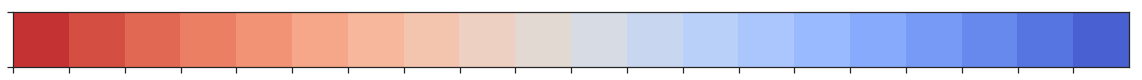

In [16]:
sns.palplot(sns.color_palette("coolwarm", 20)[::-1])
# sns.diverging_palette(20, 220, n=array_size,)

In [17]:
genome_info.hits.sort_values(by=['array_id', 'spacer_pos']).query("hit_ident < 90")

,seq_x,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,type,class,num_genes,new_type_group,seq_y,orientation,start_genome
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


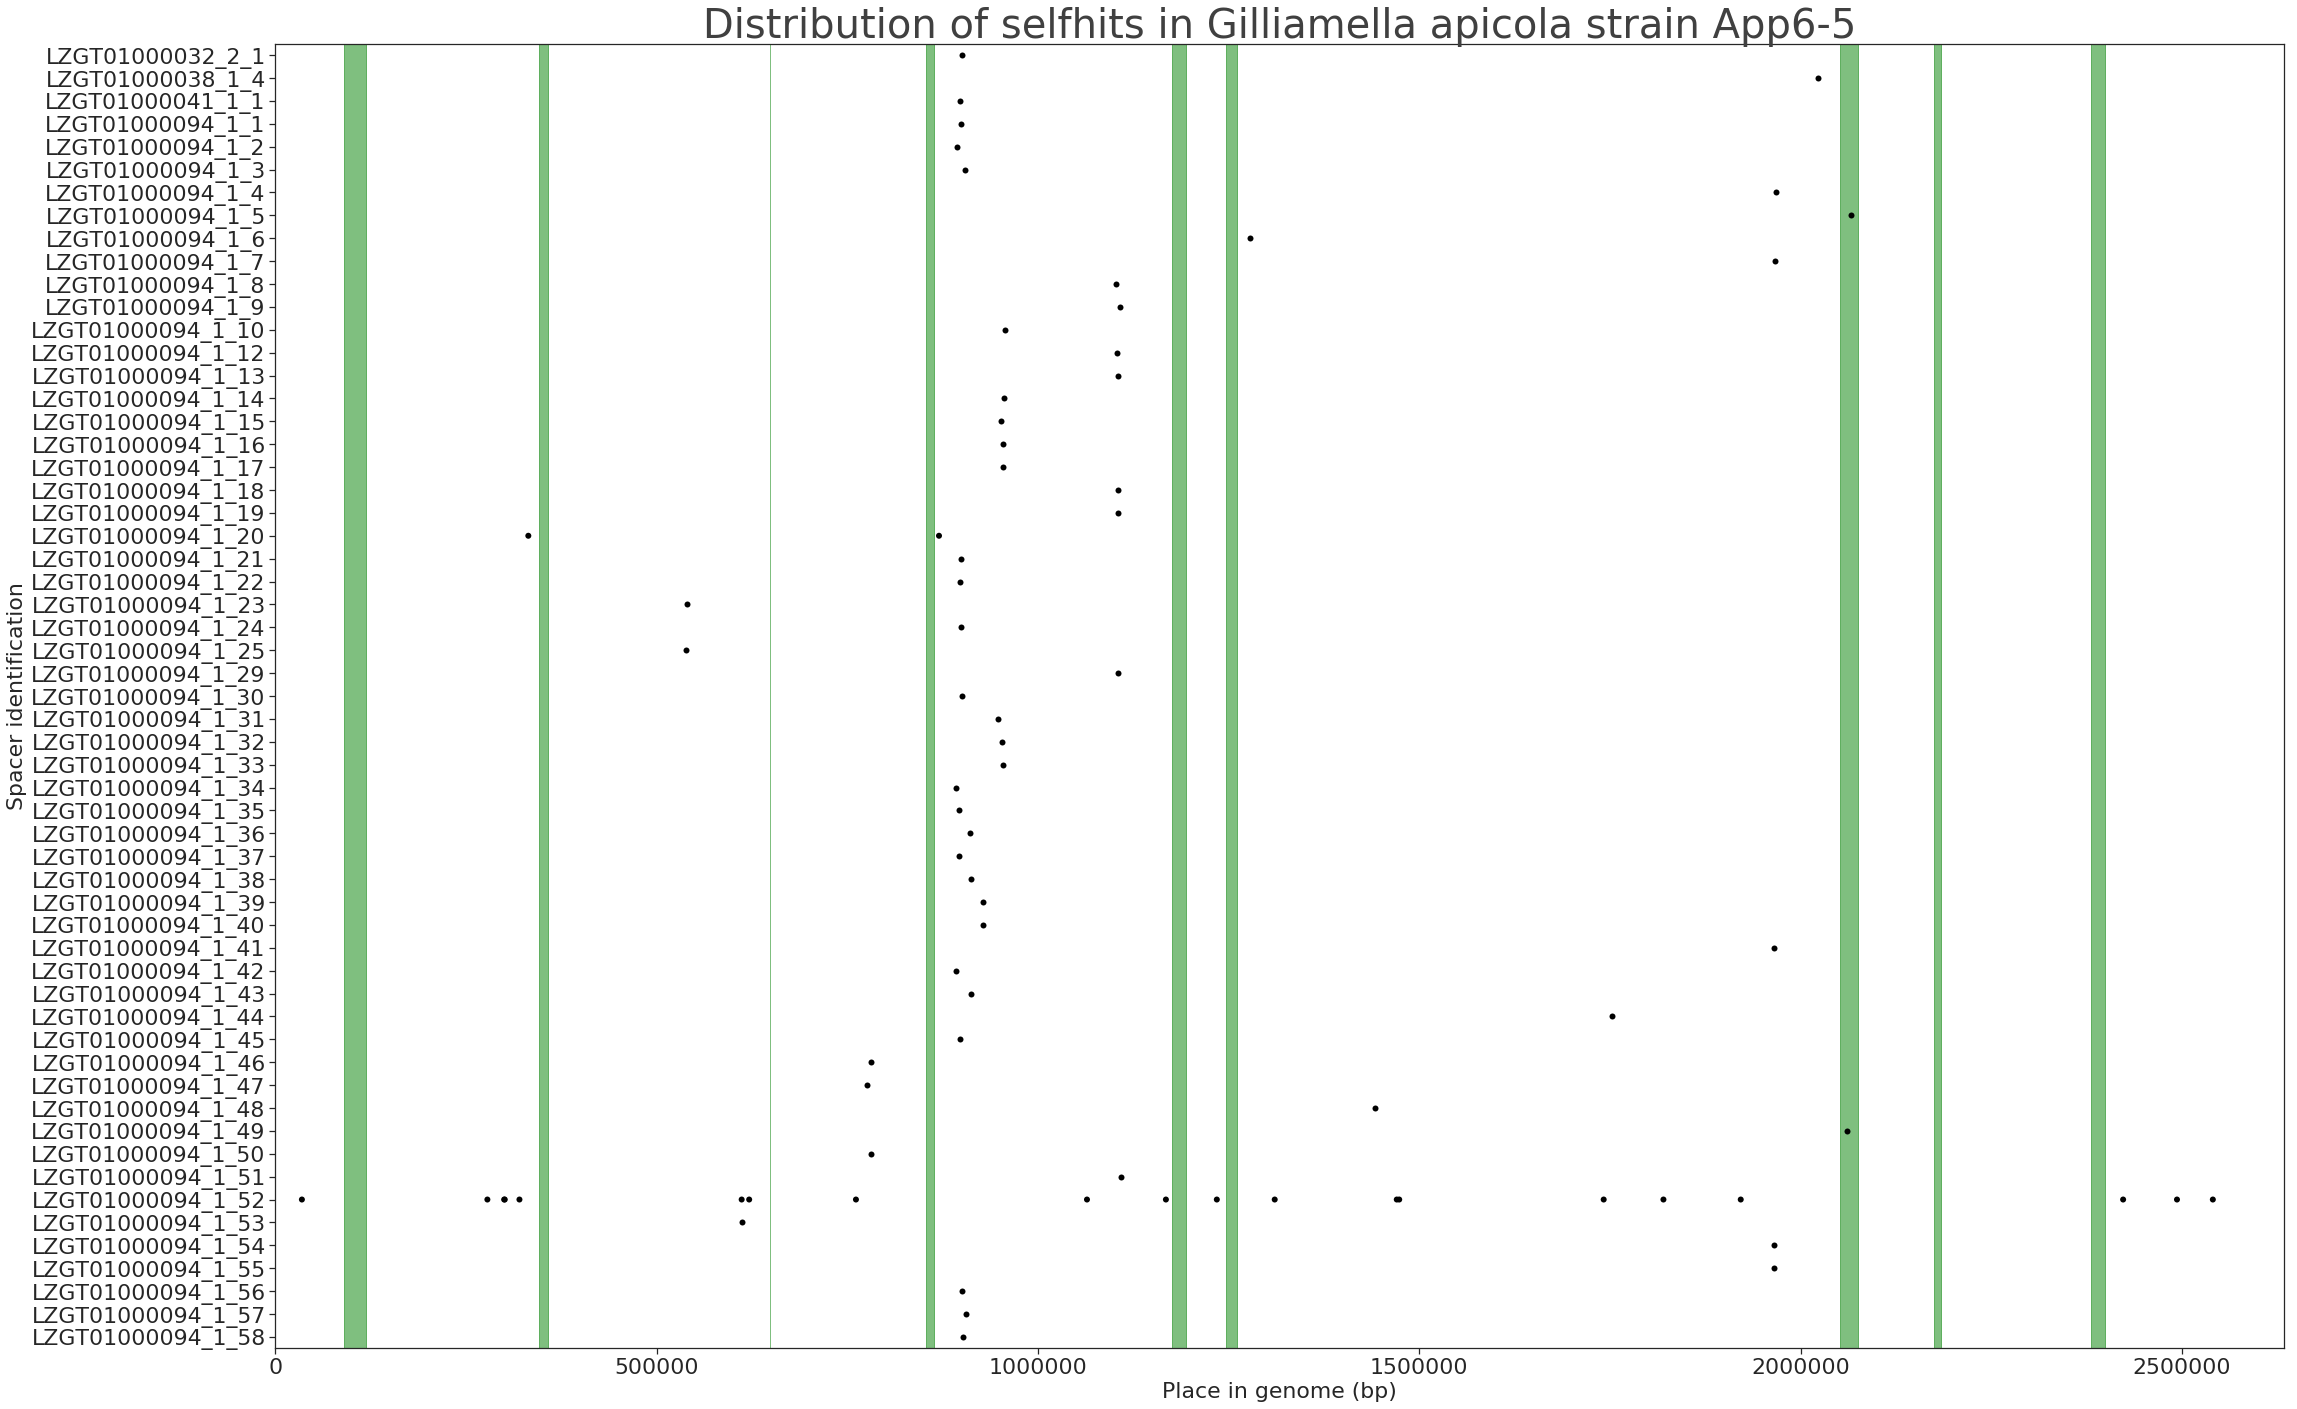

In [18]:
# plt.style.use('ggplot')
if True:
    rc['axes.facecolor'] = 'white'
    sns.set(rc=rc)

    ax = sns.stripplot(data=genome_info.hits.sort_values(by=['array_id', 'spacer_pos']), 
                       x='start_genome', jitter=0, size=6, y='spacer_id', 
                       palette=['black'])
    increase_size_by(6, 22, plt)
    # import matplotlib.transforms as mtransforms
    # trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for span in genome_info.virsorter_coords:
        ax.axvspan(*span, alpha=.5, color='green')
    # plt.savefig("place_of_hits_" + genome + ".png", format='png', bbox_inches='tight')
    plt.xlim((1, genome_info.max_length))
    plt.title("Distribution of selfhits in %s" % genome_info.name, size=40)
    plt.xlabel("Place in genome (bp)")
    plt.ylabel("Spacer identification")
#     plt.savefig("/home/hielke/bep/jups/genome_figs/%s.png" % genome, format='png', bbox_inches='tight')

For correct title placement, see `Hitplotter.figure_cleanup`.

figure saved in /home/hielke/bep/figs/indian_lake_bac/A1___Distribution_of_selfhits_in_Gilliamella_apicola_strain_App6-5.png


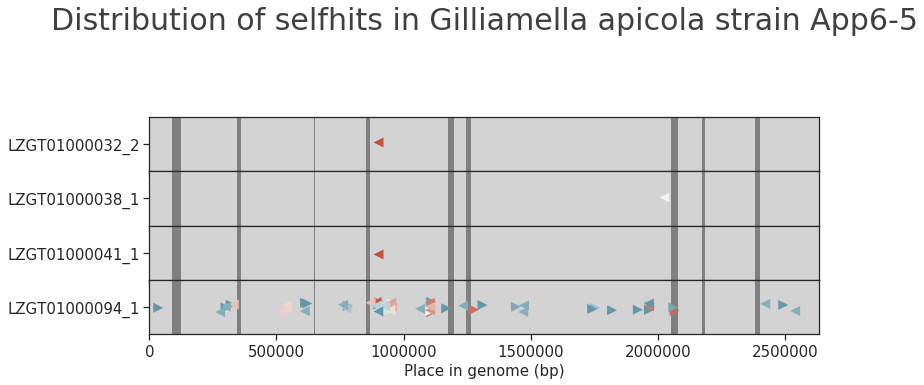

In [19]:
# rc['axes.facecolor'] = (.15, .15, .15, .3)
rc['axes.facecolor'] = 'lightgray'
sns.set(rc=rc)

class HitPlotter:
    """This class plots the hits."""
    
    def __init__(self, y, hue, arrays_num, genome_info, palette_fun=None, dfa=None, dfa_arrays=None):
        self.dfa = genome_info.hits if dfa is None else dfa
        self.dfa_arrays = genome_info.arrays if dfa_arrays is None else dfa_arrays
        self.y = y
        self.hue = hue
        self.arrays_num = arrays_num
        self.fig_size = (arrays_num, 1)
        self.fig, self.axes = plt.subplots(*self.fig_size, sharex=True)
        self.axes = self.axes if hasattr(self.axes, '__getitem__') else [self.axes]
        self.cur_plot = 0
        self.palette_fun = palette_fun or (lambda array_size: sns.diverging_palette(20, 220, n=array_size,))
        self.genome_info = genome_info

        
    def plot_orientation(self, data, palette, ax):
        from functools import partial
        plot_hits = partial(
            sns.stripplot, 
            ax=ax, 
            x='start_genome', 
            jitter=True, 
            size=10, 
            y=self.y, 
            hue=self.hue, 
        )
        
        forward_spacer_pos_palette = [palette[getattr(i, self.hue)] 
                                      for i in data.itertuples(index=False)
                                      if i.orientation]
        backward_spacer_pos_palette = [palette[getattr(i, self.hue)] 
                                      for i in data.itertuples(index=False)
                                      if not i.orientation]
        # Forward
        if any(data.orientation):
            plot_hits(data=data[data.orientation], marker='>', palette=forward_spacer_pos_palette)
        # Backward
        if not all(data.orientation):
            plot_hits(data=data[~data.orientation], marker='<', palette=backward_spacer_pos_palette)
    
    
    def plot_on_fig(self, array_name, array_size, ax):
        spacer_pos_palette = [0] + self.palette_fun(array_size)
        self.plot_orientation(self.dfa.query('%s == @array_name' % self.y).sort_values(by=self.hue),
                              spacer_pos_palette, ax)
    
    
    def plot_array(self, array_name, array_size):
        self.plot_on_fig(array_name, array_size, self.axes[self.cur_plot])
        self.cur_plot += 1
        
    
    def plot_all_arrays(self):
        plot_names = []
        for array_tuple in ([namedtuple("Row", self.dfa_arrays.index)(*self.dfa_arrays)] 
                     if type(self.dfa_arrays) is pd.Series 
                     else self.dfa_arrays.itertuples(index=False)):
            if array_tuple.array_id not in self.dfa['array_id'].values:
                continue

            plot_names.append(array_tuple.array_id)
            self.plot_array(array_tuple.array_id, array_tuple.size)
        
        return plot_names
        
        
        
    def add_virsorter(self, virsorter_coords=None):
        for span in (self.genome_info.virsorter_coords if virsorter_coords is None else virsorter_coords):
            for ax in self.axes:
                ax.axvspan(*span, alpha=1, color='gray')
        
    
    def figure_cleanup(self, title_adjustment=2.6):
        """The title is often wrongly placed. Manually configure this with the title_adjustment parameter."""
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.xlim((1, self.genome_info.max_length))
        increase_figsize((2, 1))
        for ind, ax in enumerate(self.axes):
            ax.set_ylabel("")
            ax.get_legend().remove()
            
        if title_adjustment:
            title = "Distribution of selfhits in %s" % self.genome_info.name
            plt.title(title, size=30, y=title_adjustment)
        plt.xlabel("Place in genome (bp)")
        

def normal_plot(genome_info, title_adjustment=2.6):
    
    y = 'array_id'
    hue = 'spacer_pos'
    
    palette_fun = lambda array_size: sns.color_palette("coolwarm", array_size)[::-1]
    palette_fun = lambda array_size: sns.diverging_palette(20, 220, n=array_size,)
    
    plotter = HitPlotter(y=y, hue=hue, 
                         arrays_num=len(genome_info.hits['array_id'].unique()), 
                         palette_fun=palette_fun,
                         genome_info=genome_info, )
    
    plotter.plot_all_arrays()
                
    plotter.add_virsorter()
    plotter.figure_cleanup(title_adjustment)
    
    return plotter.fig


def priming_example_plot():
    # Specific plot for this genome: "907.4"
    #
    # CRISPR Detect splits the arrays incorrectly for this genome: 
    # 
    # Correct single arrays:
    # 1-3 (Forward), 4-6 (Forward), 7-9 (Reverse), 10-13 (Reverse) 
    # 
    # This is based on adjacency and equal CRISPR repeat.
    # 
    # There are self-hits in 4-6 (Forward) and 10-13 (Reverse)
    # The size of these are:
    # 4: 22
    # 5: 8
    # 6: 4
    #
    # 10: 2
    # 11: 21
    # 12: 22
    # 13: 6
    #
    # Cumulative (NB: 10-13 is Reverse)
    #
    # 4: 0
    # 5: 22
    # 6: 30
    # (size: 34)
    #
    # 10: 49
    # 11: 28
    # 12: 6
    # 13: 0
    # (size: 51)
    
    assert genome_info.id == '907.4', "The `genome_info` object is not '907.4'"
    
    actual_spacer_pos_start = {
        4: 0, 
        5: 22, 
        6: 30, 
        10: 49,
        11: 28, 
        12: 6,
        13: 0,
    }
    dfa = genome_info.hits.pipe(lambda d:
             d.assign(
             array=np.where(
                 d['array_id'].str.len() == 12, "Reversed_array", "Forwards_array"),
             actual_spacer_pos=
                  d['array_id'].str.split('_').str.get(-1).astype(int).apply(actual_spacer_pos_start.get)
                  + d['spacer_pos'])
    )
    
    y = 'array'
    hue = 'actual_spacer_pos'
    arrays_num = 2
    plot_names = ["Reversed_array", "Forwards_array"]
    
    # Plotting
    palette_fun = lambda array_size: sns.color_palette("coolwarm", array_size)[::-1]
    palette_fun = lambda array_size: sns.diverging_palette(20, 220, n=array_size,)
    
    plotter = HitPlotter(y=y, hue=hue, 
                         arrays_num=arrays_num, palette_fun=palette_fun,
                         genome_info=genome_info, dfa=dfa)

    
    plotter.plot_array(plot_names[0], 51)
    plotter.plot_array(plot_names[1], 34)
    
    plotter.add_virsorter()
    plotter.figure_cleanup(title_adjustment=2.6)
    

if plot_lake_bacteria:
    for bac in lake_bacteria:
        genome_info = get_genome_info(bac, verbose=False)
        normal_plot(genome_info, title_adjustment=None)
        save_fig(title=genome_info.name)
elif genome == "907.4":
    priming_example_plot()
    save_fig()
else:
    normal_plot(genome_info, title_adjustment=5.5)
    save_fig()


## More information about the lake bacteria

In [20]:
set_lake_bacteria = set(lake_bacteria)

Get correct order of the plots

In [21]:
for n in [getattr(get_genome_info(bac, verbose=False), 'name') for bac in lake_bacteria]:
    print(n)

Xanthomonas oryzae pv. oryzae strain IXO221
Xanthomonas oryzae pv. oryzae strain BXO590
Xanthomonas oryzae pv. oryzae strain DXO-116
Xanthomonas oryzae pv. oryzae strain DXO-091
Xanthomonas oryzae pv. oryzae strain DXO-170
Xanthomonas oryzae pv. oryzae strain IXO35
Xanthomonas oryzae pv. oryzae strain IXO92
Xanthomonas oryzae pv. oryzae strain IXO141
Xanthomonas oryzae pv. oryzae strain IXO390
Xanthomonas oryzae pv. oryzae strain IXO134
Xanthomonas oryzae pv. oryzae strain IXO89
Xanthomonas oryzae pv. oryzae strain IXO74
Xanthomonas oryzae pv. oryzae strain DXO-174
Xanthomonas oryzae pv. oryzae strain DXO-133
Xanthomonas oryzae pv. oryzae strain DXO-50
Xanthomonas oryzae pv. oryzae strain BXO407
Xanthomonas oryzae pv. oryzae strain BXO554
Xanthomonas oryzae pv. oryzae strain BXO1
Xanthomonas oryzae pv. oryzae strain BXO34
Xanthomonas oryzae pv. oryzae strain BXO589


Check PAM

In [22]:
for bac in lake_bacteria:
    pam_conf = get_genome_info(bac, verbose=False).hits['PAM_confid'].value_counts(normalize=True)
    print("%.2f %% has correct PAM" % (100 * pam_conf.loc[3]))
    print("%.2f %% has incorrect PAM" % (100 * pam_conf.loc[0]))
    print("====")

62.50 % has correct PAM
37.50 % has incorrect PAM
====
41.67 % has correct PAM
58.33 % has incorrect PAM
====
73.91 % has correct PAM
26.09 % has incorrect PAM
====
69.23 % has correct PAM
30.77 % has incorrect PAM
====
80.00 % has correct PAM
20.00 % has incorrect PAM
====
63.33 % has correct PAM
36.67 % has incorrect PAM
====
64.29 % has correct PAM
35.71 % has incorrect PAM
====
57.14 % has correct PAM
42.86 % has incorrect PAM
====
60.00 % has correct PAM
40.00 % has incorrect PAM
====
73.68 % has correct PAM
26.32 % has incorrect PAM
====
75.00 % has correct PAM
25.00 % has incorrect PAM
====
62.07 % has correct PAM
37.93 % has incorrect PAM
====
76.92 % has correct PAM
23.08 % has incorrect PAM
====
65.38 % has correct PAM
34.62 % has incorrect PAM
====
62.50 % has correct PAM
37.50 % has incorrect PAM
====
64.29 % has correct PAM
35.71 % has incorrect PAM
====
53.85 % has correct PAM
46.15 % has incorrect PAM
====
63.16 % has correct PAM
36.84 % has incorrect PAM
====
66.67 % ha

In [23]:
dfl_names = df_genome_info[df_genome_info.index.isin(set_lake_bacteria)]
dfl_names = dfl_names['name']
dfl_names

genome_id
64187.128     Xanthomonas oryzae pv. oryzae strain IXO221
64187.133     Xanthomonas oryzae pv. oryzae strain BXO590
64187.136    Xanthomonas oryzae pv. oryzae strain DXO-116
64187.137    Xanthomonas oryzae pv. oryzae strain DXO-091
64187.140    Xanthomonas oryzae pv. oryzae strain DXO-170
64187.148      Xanthomonas oryzae pv. oryzae strain IXO35
64187.149      Xanthomonas oryzae pv. oryzae strain IXO92
64187.153     Xanthomonas oryzae pv. oryzae strain IXO141
64187.158     Xanthomonas oryzae pv. oryzae strain IXO390
64187.205     Xanthomonas oryzae pv. oryzae strain IXO134
64187.209      Xanthomonas oryzae pv. oryzae strain IXO89
64187.210      Xanthomonas oryzae pv. oryzae strain IXO74
64187.217    Xanthomonas oryzae pv. oryzae strain DXO-174
64187.219    Xanthomonas oryzae pv. oryzae strain DXO-133
64187.223     Xanthomonas oryzae pv. oryzae strain DXO-50
64187.87      Xanthomonas oryzae pv. oryzae strain BXO407
64187.88      Xanthomonas oryzae pv. oryzae strain BXO554
6418

In [24]:
dfl_arrays = df_arrays[df_arrays.index.isin(set_lake_bacteria)]
dfl_spacers = dfl_arrays.groupby(by='genome_id')['size'].sum().sort_values(ascending=False)
dfl_spacers

genome_id
64187.140    91
64187.136    89
64187.149    88
64187.87     88
64187.93     88
64187.90     87
64187.137    87
64187.223    86
64187.219    86
64187.210    86
64187.148    86
64187.99     84
64187.205    84
64187.217    84
64187.88     84
64187.128    82
64187.133    74
64187.153    73
64187.158    73
64187.209    68
Name: size, dtype: int64

In [25]:
dfl = df[df.index.isin(set_lake_bacteria)]
dfl = dfl.query('hit_ident > 90')
dfl_hits = dfl.groupby(by='genome_id').size().sort_values(ascending=False)

In [26]:
dfl_hits.to_frame('hits').join(dfl_spacers.to_frame('spacers')).join(dfl_names.to_frame('name')) \
    .to_csv('/home/hielke/bep/lake/genome_info', sep='\t')